<a href="https://colab.research.google.com/github/IsfaquethedataAnalyst/Dataanalysis/blob/main/Supply_Chain_Analytics_Understanding_Customers_with_Cohort_Analysis%2C_RFM_Analysis%2C_and_K_Means_Clustering_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cartopy.crs as ccrs
from matplotlib.colors import Normalize
%matplotlib inline

# Load the retail data
data = pd.read_csv('/content/online_retail_II.csv')
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
505929,536592,85064,CREAM SWEETHEART LETTER RACK,1.0,2010-12-01 17:06:00,11.02,NaN,United Kingdom
505930,536592,85099B,JUMBO BAG RED RETROSPOT,1.0,2010-12-01 17:06:00,4.21,NaN,United Kingdom
505931,536592,85099F,JUMBO BAG STRAWBERRY,1.0,2010-12-01 17:06:00,4.21,NaN,United Kingdom
505932,536592,85114A,BLACK ENCHANTED FOREST PLACEMAT,4.0,2010-12-01 17:06:00,3.36,NaN,United Kingdom


In [9]:
# How many countries are included in this dataset?
data['Country'].nunique()

40

In [10]:
# How many observations per countries are included in this dataset?
country_counts = data['Country'].value_counts()
country_counts

United Kingdom          467341
EIRE                      9514
Germany                   7897
France                    5521
Netherlands               2769
Spain                     1233
Switzerland               1181
Belgium                   1042
Portugal                  1021
Sweden                     902
Channel Islands            889
Italy                      706
Australia                  646
Cyprus                     554
Austria                    537
Greece                     517
United Arab Emirates       432
Denmark                    408
Finland                    354
Unspecified                310
Norway                     295
USA                        244
Japan                      207
Poland                     186
Malta                      172
Lithuania                  119
Singapore                  117
RSA                        111
Bahrain                    107
Canada                      77
Hong Kong                   76
Thailand                    76
Israel  

In [11]:
# Create a UK dataset
df_uk = data[data.Country == 'United Kingdom']
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 467341 entries, 0 to 505932
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      467341 non-null  object 
 1   StockCode    467341 non-null  object 
 2   Description  464510 non-null  object 
 3   Quantity     467341 non-null  float64
 4   InvoiceDate  467341 non-null  object 
 5   Price        467341 non-null  float64
 6   Customer ID  367545 non-null  float64
 7   Country      467341 non-null  object 
dtypes: float64(3), object(5)
memory usage: 32.1+ MB


In [17]:
from mpl_toolkits.basemap import Basemap

In [23]:
# Fix the error by applying pd.to_datetime to the entire column
df_date['InvoiceDate'] = pd.to_datetime(df_date['InvoiceDate'])

# Rest of your code
df_date.loc[:, 'Month'] = df_date['InvoiceDate'].dt.to_period('M')
monthly_counts = df_date.groupby('Month').size()

<ipython-input-23-267e22d6a5ff>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_date.loc[:, 'Month'] = df_date['InvoiceDate'].dt.to_period('M')


In [24]:
print(monthly_counts)

Month
2009-12    42857
2010-01    29243
2010-02    27154
2010-03    38806
2010-04    31402
2010-05    32377
2010-06    37117
2010-07    30582
2010-08    30761
2010-09    37822
2010-10    53946
2010-11    72438
2010-12     2836
Freq: M, dtype: int64


In [26]:
# How many unique orders are there each month?
monthly_unique_orders = df_date.groupby('Month')['Customer ID'].nunique()
monthly_unique_orders

Month
2009-12     986
2010-01     719
2010-02     748
2010-03    1033
2010-04     926
2010-05     992
2010-06    1018
2010-07     907
2010-08     898
2010-09    1097
2010-10    1446
2010-11    1549
2010-12      87
Freq: M, Name: Customer ID, dtype: int64

In [28]:
# Remove incoomplete December 2011 from the dataset to explore monthly customer retention rate
df_uk = df_uk[df_uk['InvoiceDate'].dt.date < dt.date(2011, 12, 1)]

# Double check that the month Dec. 2011 was removed from the data
df_date = df_uk.copy()
df_date.loc[:, 'Month'] = df_date['InvoiceDate'].dt.to_period('M')
monthly_counts = df_date.groupby('Month').size()
monthly_counts

# Find the month when the customers made their first purchase
first_purchase_month = df_uk.groupby('Customer ID')['InvoiceDate'].min().dt.to_period('M')
first_purchase_month = first_purchase_month.to_frame()
first_purchase_month.columns = ['Cohort']
first_purchase_month.head()

,Cohort
Customer ID,
12346.0,2009-12
12608.0,2010-10
12745.0,2010-05
12746.0,2009-12
12747.0,2009-12


No charts were generated by quickchart


In [37]:
# Set the 'CustomerID' column as the index for a dataframe df_uk, join it with first_purchase_month
# The result, stored in df_uk_cohort, facilitates cohort analysis based on customer acquisition timing.
df_uk_cohort = df_uk.set_index('Customer ID').join(first_purchase_month)

# Convert InvoiceDate to month and create a SalesPeriod column
df_uk_cohort['SalesPeriod']=df_uk_cohort['InvoiceDate'].dt.to_period('m')

# Reset the index of df_uk_cohort and then perform a grouped count of unique CustomerIDs based on the 'Cohort' and 'SalesPeriod' columns
# This provides insights into customer retention over time
df_uk_cohort.reset_index(inplace=True)
df_uk_cohort.groupby(['Cohort', 'SalesPeriod']).agg({'Customer ID': 'nunique'})

Customer ID
Cohort  SalesPeriod             
2009-12 2009-12              986
        2010-01              368
        2010-02              334
        2010-03              418
        2010-04              387
...                          ...
2010-10 2010-11               96
        2010-12                4
2010-11 2010-11              302
        2010-12                6
2010-12 2010-12                6

[91 rows x 1 columns]

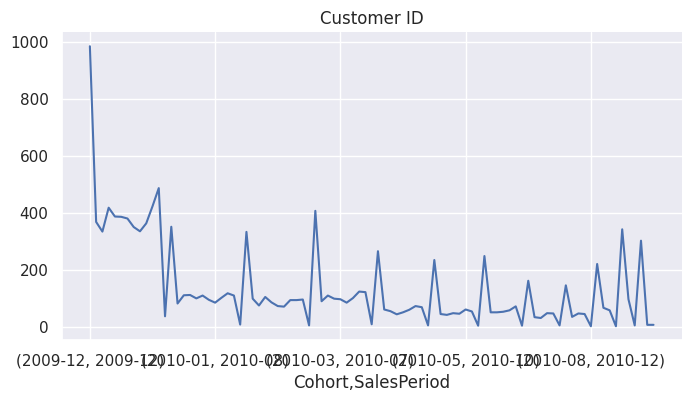

In [36]:
from matplotlib import pyplot as plt
_df_1['Customer ID'].plot(kind='line', figsize=(8, 4), title='Customer ID')
plt.gca().spines[['top', 'right']].set_visible(False)

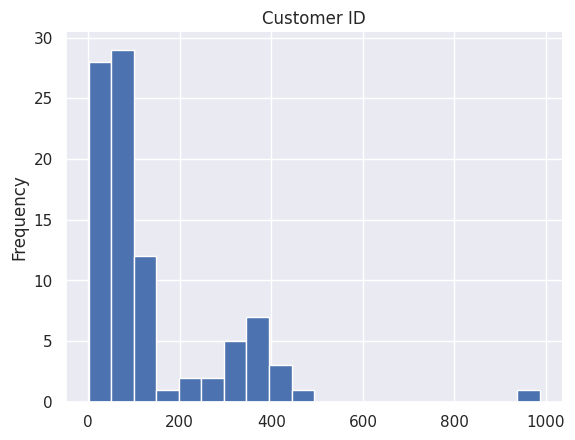

In [34]:
from matplotlib import pyplot as plt
_df_0['Customer ID'].plot(kind='hist', bins=20, title='Customer ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [40]:
# Group the dataframe df_uk_cohort by 'Cohort' and 'SalesPeriod'
# Count the number of unique CustomerIDs in each group
# Reset the index and create a new dataframe, retention
retention = df_uk_cohort.groupby(['Cohort', 'SalesPeriod']).agg({'Customer ID': 'nunique'}).reset_index()

# Pivot the data
retention_pivot = retention.pivot(index='SalesPeriod', columns='Cohort', values='Customer ID')

In [41]:
print(retention_pivot)

Cohort       2009-12  2010-01  2010-02  2010-03  2010-04  2010-05  2010-06  \
SalesPeriod                                                                  
2009-12        986.0      NaN      NaN      NaN      NaN      NaN      NaN   
2010-01        368.0    351.0      NaN      NaN      NaN      NaN      NaN   
2010-02        334.0     81.0    333.0      NaN      NaN      NaN      NaN   
2010-03        418.0    110.0     98.0    407.0      NaN      NaN      NaN   
2010-04        387.0    111.0     74.0     89.0    265.0      NaN      NaN   
2010-05        386.0     99.0    104.0    109.0     60.0    234.0      NaN   
2010-06        380.0    109.0     85.0     98.0     54.0     44.0    248.0   
2010-07        350.0     94.0     72.0     96.0     43.0     41.0     50.0   
2010-08        335.0     84.0     70.0     84.0     50.0     47.0     50.0   
2010-09        363.0    101.0     93.0    100.0     59.0     45.0     52.0   
2010-10        423.0    117.0     93.0    123.0     72.0     60.

In [42]:
# Build a function that calculates the retention rate
def calculate_retention_rate(df):
    for x in range(len(df)):
        df.iloc[:,x] = df.iloc[:,x].divide(df.iloc[x,x])
    return df

retention_pivot = calculate_retention_rate(retention_pivot)
retention_pivot

Cohort,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12
SalesPeriod,,,,,,,,,,,,,
2009-12,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01,0.373225,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02,0.338742,0.230769,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03,0.423935,0.313390,0.294294,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04,0.392495,0.316239,0.222222,0.218673,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05,0.391481,0.282051,0.312312,0.267813,0.226415,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06,0.385396,0.310541,0.255255,0.240786,0.203774,0.188034,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,0.354970,0.267806,0.216216,0.235872,0.162264,0.175214,0.201613,1.000000,NaN,NaN,NaN,NaN,NaN
2010-08,0.339757,0.239316,0.210210,0.206388,0.188679,0.200855,0.201613,0.204969,1.000000,NaN,NaN,NaN,NaN


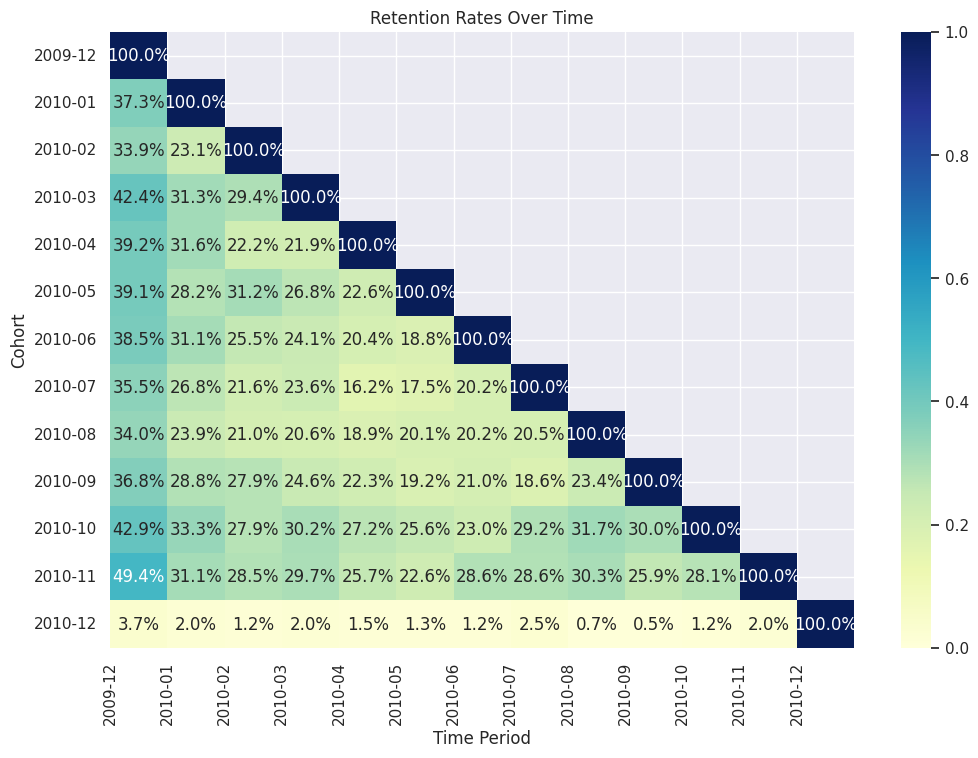

In [43]:
# Create a mask to hide the upper half, and visualize this data
mask = np.triu(np.ones_like(retention_pivot), k=1)

plt.figure(figsize=(12, 8))
sns.heatmap(retention_pivot, annot=True, fmt=".1%", cmap="YlGnBu", vmin=0, vmax=1, mask=mask)

plt.title('Retention Rates Over Time')
plt.xlabel('Time Period')
plt.ylabel('Cohort')
plt.xticks(ticks=range(len(retention_pivot.columns)), labels=retention_pivot.columns)
plt.show()

In [46]:
# Plot monthly revenue amount by cohort
cohort_amount = df_uk_cohort.groupby(['Cohort', 'SalesPeriod'])['Price'].sum().reset_index()
cohort_amount

,Cohort,SalesPeriod,Price
0,2009-12,2009-12,95891.280
1,2009-12,2010-01,56089.321
2,2009-12,2010-02,34596.902
3,2009-12,2010-03,43815.150
4,2009-12,2010-04,45150.880
...,...,...,...
86,2010-10,2010-11,11265.530
87,2010-10,2010-12,83.040
88,2010-11,2010-11,30750.330
89,2010-11,2010-12,337.700


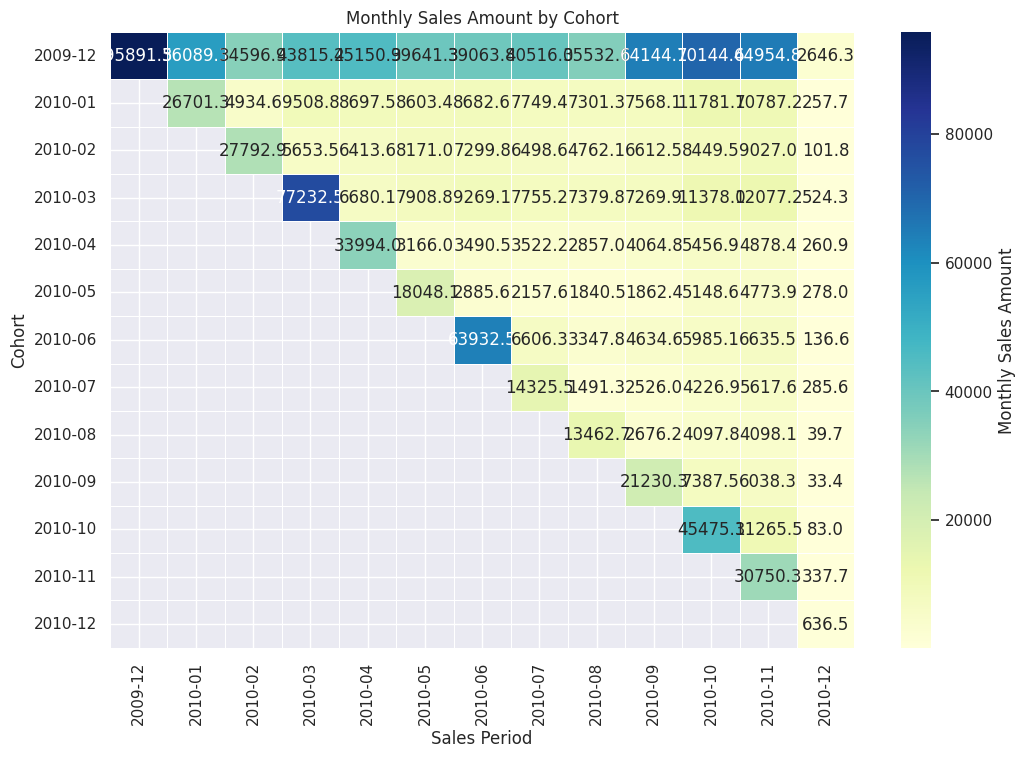

In [47]:
# Visualize the data
plt.figure(figsize=(12, 8))
heatmap_data = cohort_amount.pivot(index='Cohort', columns='SalesPeriod', values='Price')

sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Monthly Sales Amount'})
plt.title('Monthly Sales Amount by Cohort')
plt.xlabel('Sales Period')
plt.ylabel('Cohort')
plt.show()

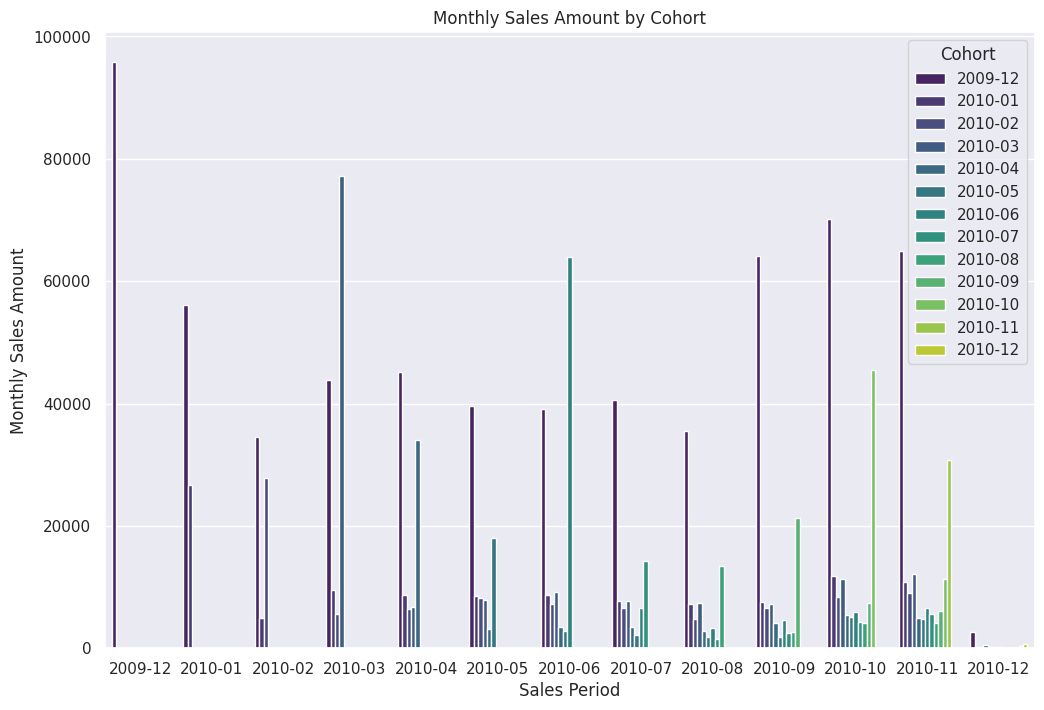

In [48]:
# Visualize the data
plt.figure(figsize=(12, 8))
sns.barplot(x='SalesPeriod', y='Price', hue='Cohort', data=cohort_amount, palette='viridis')
plt.title('Monthly Sales Amount by Cohort')
plt.xlabel('Sales Period')
plt.ylabel('Monthly Sales Amount')
plt.show()

In [80]:
# Get the total number of unique SKUs
unique_skus = df_uk_cohort['StockCode'].unique()
total_unique_skus = len(unique_skus)
print("Unique SKUs:")
print(unique_skus)
print("\nTotal Unique SKUs:", total_unique_skus)

Unique SKUs:
['TEST001' 'TEST002' 'ADJUST' ... '84596g' '90182A' '85049g']

Total Unique SKUs: 4621


In [83]:
# Display the total number of SKUs by cohort
sku_by_cohort = df_uk_cohort.groupby('Cohort')['StockCode'].nunique()
print("Total SKUs by Cohort:")
print(sku_by_cohort)


Total SKUs by Cohort:
Cohort
2009-12    3877
2010-01    3024
2010-02    2980
2010-03    3038
2010-04    2375
2010-05    2285
2010-06    2440
2010-07    1977
2010-08    1887
2010-09    1993
2010-10    2117
2010-11    2062
2010-12     145
Freq: M, Name: StockCode, dtype: int64


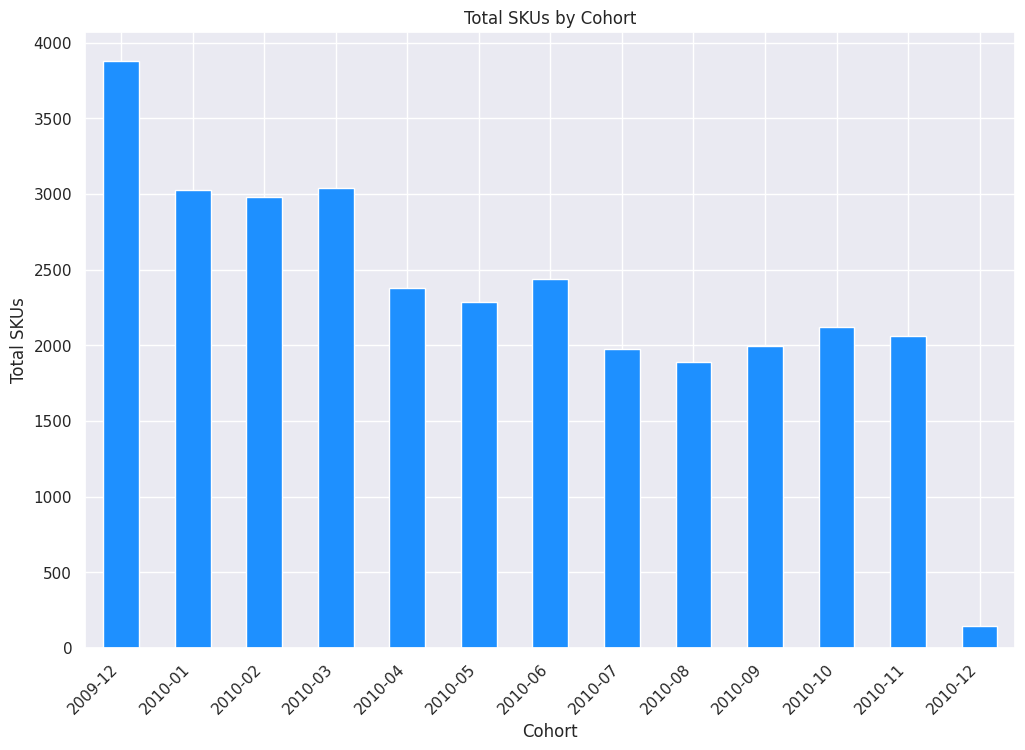

In [84]:
# Visualize
plt.figure(figsize=(12, 8))
sku_by_cohort.plot(kind='bar', color='dodgerblue')
plt.title('Total SKUs by Cohort')
plt.xlabel('Cohort')
plt.ylabel('Total SKUs')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


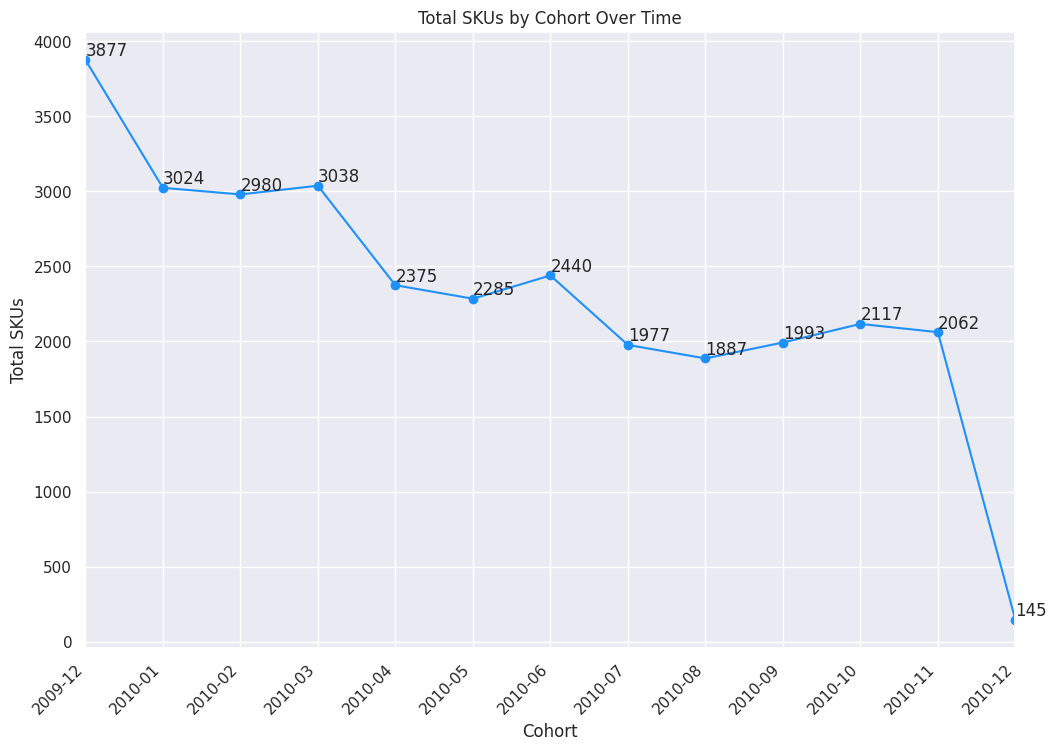

In [85]:
# Visualize
plt.figure(figsize=(12, 8))
sku_by_cohort.plot(kind='line', marker='o', color='dodgerblue')

plt.title('Total SKUs by Cohort Over Time')
plt.xlabel('Cohort')
plt.ylabel('Total SKUs')

# Add data labels
for cohort, total_sku in sku_by_cohort.items():
    plt.text(cohort, total_sku, f'{total_sku}', ha='left', va='bottom')

# Set the x-axis major ticks explicitly with the years
plt.xticks(sku_by_cohort.index, [str(year)[:7] for year in sku_by_cohort.index], rotation=45, ha='right')

plt.show()

In [88]:
# Explore the top selling products in each country

# Group the data by 'Country' and 'StockCode', then sum 'Quantity' and 'Amount' for each group
country_product_sales = data.groupby(['Country', 'StockCode']).agg({'Quantity': 'sum', 'Price': 'sum'}).reset_index()

# Find the index of the maximum 'Quantity' for each 'Country'
top_products_idx = country_product_sales.groupby('Country')['Quantity'].idxmax()

# Use the index to filter the original dataframe and get the top selling products for each country
top_products_by_country = country_product_sales.loc[top_products_idx]

# Sort the dataframe by 'Quantity' in descending order
top_products_by_country = top_products_by_country.sort_values(by='Quantity', ascending=False)

top_products_by_country[['Country', 'StockCode', 'Quantity', 'Price']]

,Country,StockCode,Quantity,Price
17587,United Kingdom,85123A,50372.0,10035.72
2702,Denmark,37410,25164.0,0.20
11941,Sweden,16033,5760.0,0.36
10031,Netherlands,35961,5425.0,14.46
3056,EIRE,21212,4200.0,28.27
6366,Germany,20719,1545.0,63.36
5396,France,21731,1375.0,105.60
1378,Bermuda,84568,1152.0,0.21
11886,Spain,84997C,648.0,10.17
348,Australia,22951,504.0,0.97


In [89]:
# Explore the top selling products in the UK
selected_product = data[(data['Country'] == 'United Kingdom') & (data['StockCode'] == 23843) & (data['Quantity'] == 80995)]

selected_product # This came from one order

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


In [93]:
# Explore the top selling product from the Canada
selected_product = data[(data['Country'] == 'Canada') & (data['StockCode'] == 20996	)]
print(selected_product) # This came from several orders

Empty DataFrame
Columns: [Invoice, StockCode, Description, Quantity, InvoiceDate, Price, Customer ID, Country]
Index: []


In [95]:
# Are the products the same or different in the top sellers list?
country_product_sales = data.groupby(['Country', 'StockCode', 'Description']).agg({'Quantity': 'sum', 'Price': 'sum'}).reset_index()

# Find the index of the maximum 'Quantity' for each 'Country'
top_products_idx = country_product_sales.groupby('Country')['Quantity'].idxmax()

# Use the index to filter the original data and get the top selling products for each country
top_products_by_country = country_product_sales.loc[top_products_idx]

# Sort by 'Quantity' in descending order
top_products_by_country = top_products_by_country.sort_values(by='Quantity', ascending=False)

top_products_by_country[['Country', 'StockCode', 'Description', 'Quantity', 'Price']]

,Country,StockCode,Description,Quantity,Price
18839,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,50564.0,10035.72
2834,Denmark,37410,BLACK AND WHITE PAISLEY FLOWER MUG,25164.0,0.20
12710,Sweden,16033,MINI HIGHLIGHTER PENS,5760.0,0.36
10719,Netherlands,35961,FOLKART ZINC HEART CHRISTMAS DEC,5425.0,14.46
3220,EIRE,21212,PACK OF 72 RETRO SPOT CAKE CASES,4080.0,25.52
5641,France,21392,RED SPOTTY PUDDING BOWL,3690.0,10.63
6816,Germany,20719,WOODLAND CHARLOTTE BAG,1545.0,63.36
1467,Bermuda,84568,GIRLS ALPHABET IRON ON PATCHES,1152.0,0.21
12633,Spain,84879,ASSORTED COLOUR BIRD ORNAMENT,592.0,19.80
373,Australia,22951,60 CAKE CASES DOLLY GIRL DESIGN,504.0,0.97


In [96]:
# Group by 'Description' and count the occurrences
description_counts = top_products_by_country['Description'].value_counts().reset_index()

# Rename the columns for clarity
description_counts.columns = ['Description', 'Count']

description_counts

,Description,Count
0,WHITE HANGING HEART T-LIGHT HOLDER,3
1,MINI HIGHLIGHTER PENS,3
2,GIRLS ALPHABET IRON ON PATCHES,3
3,JAPANESE CROCHETED ANIMAL,1
4,VICTORIAN SEWING KIT,1
5,PLASTERS IN TIN SPACEBOY,1
6,WHITE TALL PORCELAIN T-LIGHT HOLDER,1
7,STRAWBERRY CERAMIC TRINKET BOX,1
8,PINK POLKADOT BOWL,1
9,TROPICAL HONEYCOMB PAPER GARLAND,1


Recency, Frequency, Monetary (RFM) **Analysis**

In [104]:
import pandas as pd

# Get a reference date
ref = df_uk['InvoiceDate'].max()  # Access the column correctly

# Convert the 'InvoiceDate' column to datetime format
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'])  # Apply to_datetime to the entire column

# Extract the date component
df_uk['InvoiceDate'] = df_uk['InvoiceDate'].dt.date

# Create recency, frequency, and monetary dataframes
recency = df_uk.groupby('Customer ID')['InvoiceDate'].apply(lambda x: (ref - x.max()).days)
frequency = df_uk.groupby('Customer ID')['Invoice'].nunique()
monetary = df_uk.groupby('Customer ID')['Price'].sum()


In [105]:
# View top 10 monetary values by CustomerID
top_monetary = monetary.nlargest(10)
top_monetary

Customer ID
14063.0    39920.95
12918.0    32860.50
17399.0    25111.09
17949.0    18574.98
17841.0    15148.15
15202.0    14573.16
14606.0    10946.29
12748.0     9898.35
15413.0     9416.82
14527.0     9304.14
Name: Price, dtype: float64

In [107]:
# Combine recency and frequency
df_rf = recency.to_frame(name = 'Recency').join(frequency.to_frame(name = 'Frequency'))

# Add monetary
df_rfm = df_rf.join(monetary.to_frame(name='Monetary'))

# Get 4 quantile values
quantiles = df_rfm.quantile(q=[0.2, 0.4, 0.6, 0.8])
quantiles

,Recency,Frequency,Monetary
0.2,10.0,1.0,43.514
0.4,31.0,2.0,97.718
0.6,64.0,4.0,191.402
0.8,173.0,7.0,410.080


In [108]:
# Define function for R score conversion
def Rscore(x, q, df):
    if x <= df[q][0.2]:
        return 1
    elif x <= df[q][0.4]:
        return 2
    elif x <= df[q][0.6]:
        return 3
    elif x <= df[q][0.8]:
        return 4
    else:
        return 5

# Create a copy
rfm_copy = df_rfm.copy()

# Convert to R score
rfm_copy['Rscore'] = rfm_copy['Recency'].apply(Rscore, args=('Recency',quantiles))
rfm_copy.head()

,Recency,Frequency,Monetary,Rscore
Customer ID,,,,
12346.0,58,15,578.36,3
12608.0,31,1,26.04,2
12745.0,113,2,67.98,4
12746.0,154,3,73.95,4
12747.0,7,21,694.98,1


In [109]:
# Define function for FM scores conversion
def FMscore(x, q, df):
    if x <= df[q][0.2]:
        return 1
    elif x <= df[q][0.4]:
        return 2
    elif x <= df[q][0.6]:
        return 3
    elif x <= df[q][0.8]:
        return 4
    else:
        return 5

# Applying the function to create Fscore and Mscore columns
rfm_copy['Fscore'] = rfm_copy['Frequency'].apply(FMscore, args=('Frequency', quantiles))
rfm_copy['Mscore'] = rfm_copy['Monetary'].apply(FMscore, args=('Monetary', quantiles))
rfm_copy.head()

,Recency,Frequency,Monetary,Rscore,Fscore,Mscore
Customer ID,,,,,,
12346.0,58,15,578.36,3,5,5
12608.0,31,1,26.04,2,1,1
12745.0,113,2,67.98,4,2,2
12746.0,154,3,73.95,4,3,2
12747.0,7,21,694.98,1,5,5


In [110]:
# Use the average of the R, F, M scores for RFM score
rfm_copy['RFMscore']=rfm_copy[['Rscore','Fscore','Mscore']].mean(axis=1)
rfm_copy.head()

,Recency,Frequency,Monetary,Rscore,Fscore,Mscore,RFMscore
Customer ID,,,,,,,
12346.0,58,15,578.36,3,5,5,4.333333
12608.0,31,1,26.04,2,1,1,1.333333
12745.0,113,2,67.98,4,2,2,2.666667
12746.0,154,3,73.95,4,3,2,3.000000
12747.0,7,21,694.98,1,5,5,3.666667


In [111]:
# Segment customers into different groups
def segment(df):
    if df.RFMscore <= 1:
        return 'Basic'
    elif df.RFMscore <= 2:
        return 'Bronze'
    elif df.RFMscore <= 3:
        return 'Silver'
    elif df.RFMscore <= 4:
        return 'Gold'
    elif df.RFMscore <= 4.5:
        return 'Platinum'
    else:
        return 'Diamond'

rfm_copy['LoyaltyGroup'] = rfm_copy.apply(segment, axis=1)
rfm_copy.head(n=10)

,Recency,Frequency,Monetary,Rscore,Fscore,Mscore,RFMscore,LoyaltyGroup
Customer ID,,,,,,,,
12346.0,58,15,578.36,3,5,5,4.333333,Platinum
12608.0,31,1,26.04,2,1,1,1.333333,Bronze
12745.0,113,2,67.98,4,2,2,2.666667,Silver
12746.0,154,3,73.95,4,3,2,3.000000,Silver
12747.0,7,21,694.98,1,5,5,3.666667,Gold
12748.0,0,142,9898.35,1,5,5,3.666667,Gold
12749.0,12,8,1109.23,2,5,5,4.000000,Gold
12777.0,84,1,83.21,4,1,2,2.333333,Silver
12819.0,85,1,63.35,4,1,2,2.333333,Silver


LoyaltyGroup
Silver      1734
Gold        1369
Bronze       681
Platinum     142
Diamond       46
Basic         28
Name: Customer ID, dtype: int64


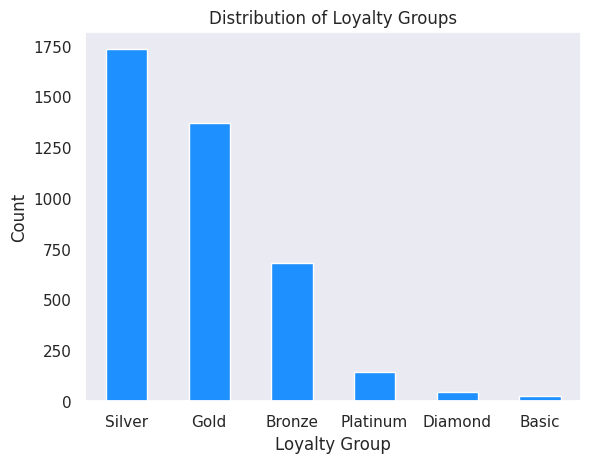

In [113]:
# Check how many customers are in each loyalty group
rfm_score = rfm_copy.reset_index()
loyalty_group_count = rfm_score.groupby('LoyaltyGroup')['Customer ID'].count().sort_values(ascending=False)
print(loyalty_group_count)

loyalty_group_count.plot(kind='bar', color='dodgerblue')
plt.grid(False)

# Add labels and title
plt.xlabel('Loyalty Group')
plt.ylabel('Count')
plt.title('Distribution of Loyalty Groups')

# Rotate x-axis labels horizontally
plt.xticks(rotation=0)

plt.show()

            Recency  Frequency  Monetary
Recency    1.000000  -0.264879 -0.096831
Frequency -0.264879   1.000000  0.429117
Monetary  -0.096831   0.429117  1.000000


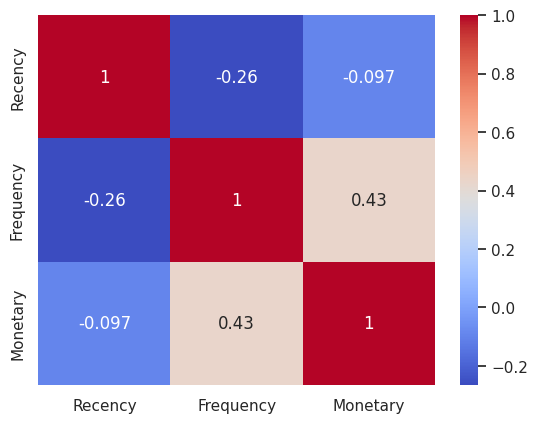

In [114]:
# Explore the correlations
correlation_matrix = rfm_copy[['Recency', 'Frequency', 'Monetary']].corr()
print(correlation_matrix)

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [115]:
# Explore summary statistics
summary_stats = rfm_copy.describe()
print(summary_stats)

          Recency    Frequency      Monetary       Rscore       Fscore  \
count  4000.00000  4000.000000   4000.000000  4000.000000  4000.000000   
mean     87.40075     5.190750    337.266693     2.987750     2.751250   
std      96.67627     8.740879   1155.719585     1.413895     1.480514   
min       0.00000     1.000000      0.000000     1.000000     1.000000   
25%      15.00000     1.000000     56.510000     2.000000     1.000000   
50%      47.00000     3.000000    136.335000     3.000000     3.000000   
75%     134.25000     6.000000    331.507500     4.000000     4.000000   
max     365.00000   154.000000  39920.950000     5.000000     5.000000   

           Mscore     RFMscore  
count  4000.00000  4000.000000  
mean      3.00000     2.913000  
std       1.41439     0.786361  
min       1.00000     1.000000  
25%       2.00000     2.333333  
50%       3.00000     3.000000  
75%       4.00000     3.666667  
max       5.00000     5.000000  


In [116]:
# Loyalty group analysis
loyalty_group_analysis = rfm_copy.groupby('LoyaltyGroup').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': 'mean'})
print(loyalty_group_analysis)

                 Recency  Frequency     Monetary
LoyaltyGroup                                    
Basic           5.250000   1.000000    22.057857
Bronze         41.534508   1.400881    53.355991
Diamond       130.586957  11.760870   900.611739
Gold           64.089116   9.804967   649.588830
Platinum       98.140845  10.049296  1242.100577
Silver        123.119954   2.531719   118.235405


    RFMscore  Count
0        1.0     28
1        1.3    104
2        1.7    218
3        2.0    359
4        2.3    606
5        2.7    596
6        3.0    532
7        3.3    470
8        3.7    567
9        4.0    332
10       4.3    142
11       4.7     43
12       5.0      3


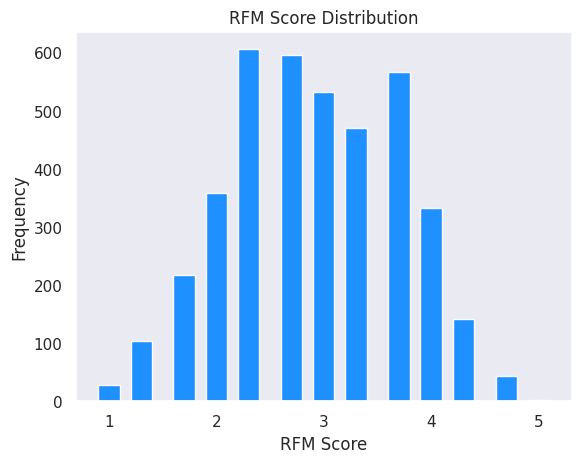

In [117]:
# RFM Score
rfm_score_distribution = rfm_copy['RFMscore'].value_counts().sort_index()

# Rounded index
rfm_score_distribution_rounded = pd.DataFrame({'RFMscore': rfm_score_distribution.index.map(lambda x: round(x, 1)), 'Count': rfm_score_distribution.values})

print(rfm_score_distribution_rounded)

rfm_score_distribution_rounded.reset_index(drop=True, inplace=True)

# Set the width of the bars
bar_width = 0.2

# Create a bar plot
plt.bar(rfm_score_distribution_rounded['RFMscore'], rfm_score_distribution_rounded['Count'], width=bar_width, color='dodgerblue')

# Add labels and title
plt.xlabel('RFM Score')
plt.ylabel('Frequency')
plt.title('RFM Score Distribution')

# Rotate x-axis labels horizontally
plt.xticks(rotation=0)

# Remove the legend and gridlines
plt.legend().set_visible(False)
plt.grid(False)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

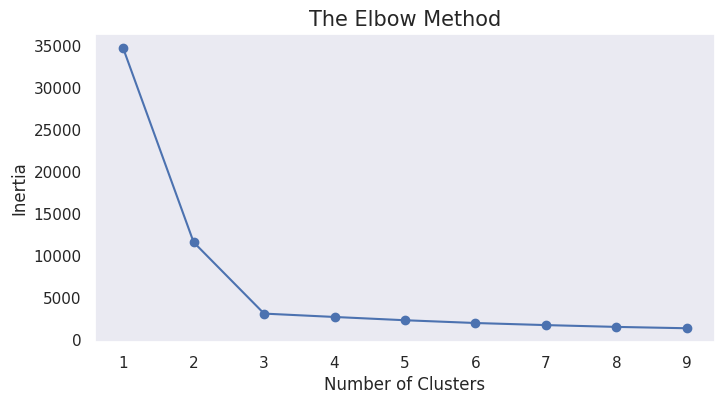

In [118]:
# Clustering with KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(n_samples=500, centers = 3, cluster_std=1.8, random_state=42)

inertia = []

for n_clusters in range(1, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

df_inertia = pd.DataFrame({'Cluster': range(1, 10), 'Inertia': inertia})

plt.figure(figsize = (8,4))
plt.plot(df_inertia.Cluster, df_inertia.Inertia, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method', fontsize=15)
plt.grid(False);

<Axes: xlabel='Monetary', ylabel='Count'>

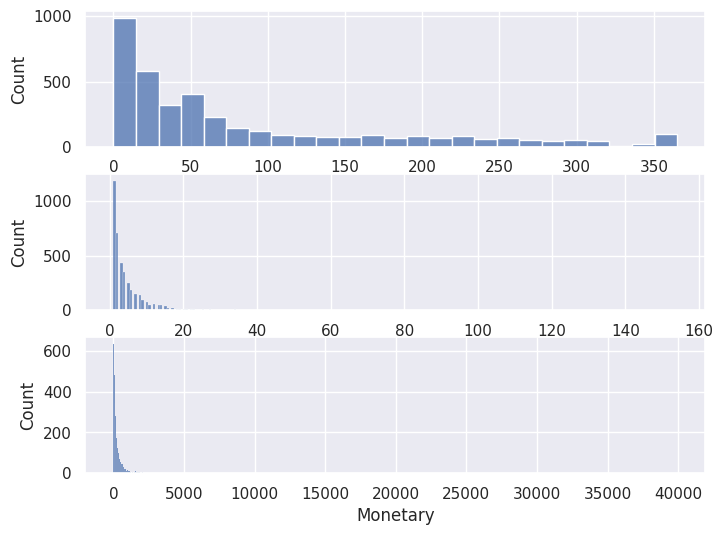

In [120]:
# KMeans data uses distance to measure, it should have a normal distribution
fig, axs = plt.subplots(3, figsize = (8,6))
sns.histplot(df_rfm['Recency'], ax=axs[0])
sns.histplot(df_rfm['Frequency'], ax=axs[1])
sns.histplot(df_rfm['Monetary'], ax=axs[2])

In [122]:
# Log transformation, to normalize the distribution
df_rfm_log = np.log1p(df_rfm)

# Replace infinite values with NaN
df_rfm.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
df_rfm.dropna(inplace=True)

# Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_rfm_scaled = scaler.fit_transform(df_rfm_log)

df_rfm_scaled = pd.DataFrame(data=df_rfm_scaled, index=df_rfm.index, columns=df_rfm.columns)

# Train kmeans model
kmeans = KMeans(n_clusters=3, random_state=42)
clusters= kmeans.fit_predict(df_rfm_scaled)
cluster_labels = kmeans.labels_

# Visualize
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig)
ax.scatter(df_rfm_scaled.Recency, df_rfm_scaled.Frequency, df_rfm_scaled.Monetary, c = cluster_labels,
           edgecolor = 'k', cmap = 'Accent')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_xlabel('Monetary')
ax.set_title('Three Clsuters', fontsize = 15)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 0.92, 'Three Clsuters')

<Figure size 800x600 with 0 Axes>

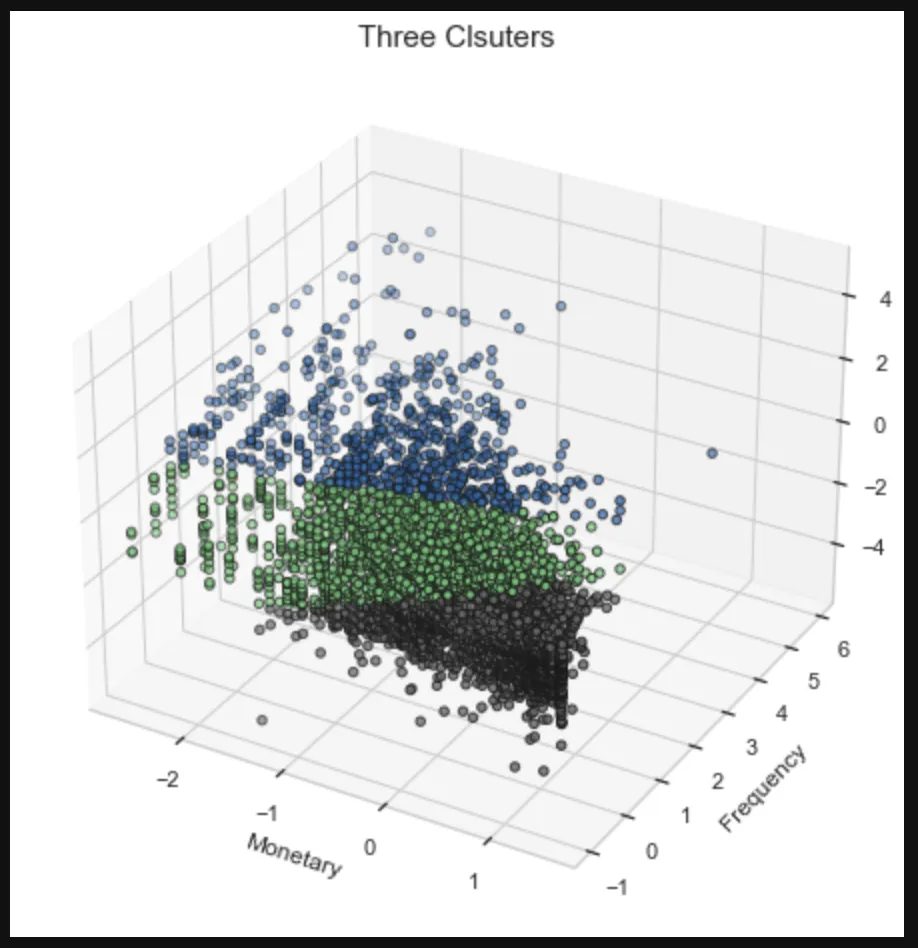

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-126-d777a3de4eaa>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Accent', 6)  # Adjust 'Accent' to the desired colormap


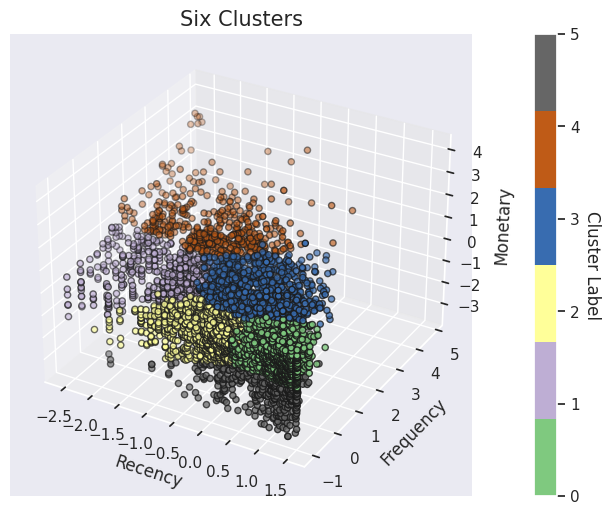

In [126]:
#Try with K = 6 for more nuanced customer groups. Train k-means model.
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(df_rfm_scaled)
cluster_labels = kmeans.labels_

# Visualize
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Specify the number of clusters in cmap
cmap = plt.cm.get_cmap('Accent', 6)  # Adjust 'Accent' to the desired colormap

scatter = ax.scatter(df_rfm_scaled.Recency, df_rfm_scaled.Frequency, df_rfm_scaled.Monetary, c=cluster_labels,
                     edgecolor='k', cmap=cmap)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Six Clusters', fontsize=15)

# Add color bar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1, ticks=range(6))  # Adjust ticks based on the number of clusters
cbar.set_label('Cluster Label', rotation=270, labelpad=15)

plt.show()

3    943
0    911
2    815
1    482
4    472
5    377
dtype: int64


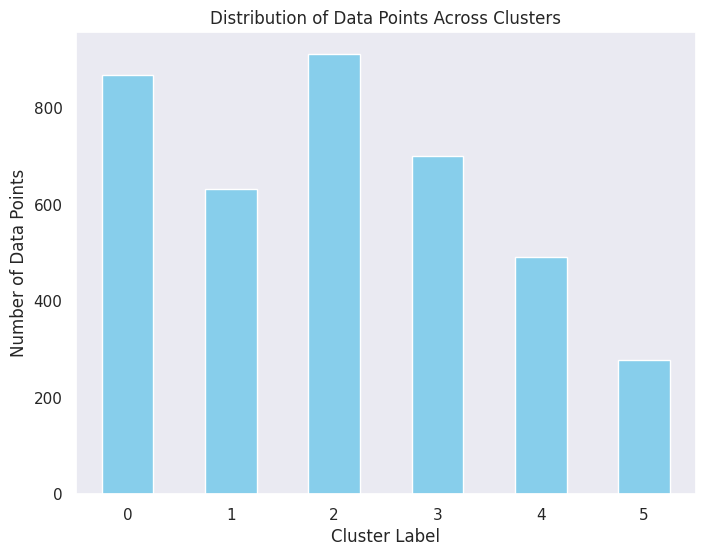

    Recency  Frequency  Monetary
0  1.051324  -0.707128 -0.372127
1 -1.462790   0.318180  0.328508
2 -0.275979  -0.643090 -0.404311
3  0.223127   0.495403  0.617440
4 -1.106166   1.862349  1.395339
5  0.750944  -0.875444 -1.935478
  Recency                                                           Frequency  \
    count        mean         std   min    25%    50%    75%    max     count   
0   911.0  203.945115   84.341765  69.0  132.0  202.0  268.0  365.0     911.0   
1   482.0    5.576763    4.367157   0.0    1.0    6.0    8.0   16.0     482.0   
2   815.0   32.168098   18.377290   1.0   16.0   29.0   47.0   72.0     815.0   
3   943.0   70.799576   54.839421  13.0   31.0   55.0   89.5  356.0     943.0   
4   472.0   12.495763   14.679303   0.0    3.0    8.0   16.0  129.0     472.0   
5   377.0  165.098143  108.334556   1.0   64.0  152.0  258.0  365.0     377.0   

              ...              Monetary                                    \
        mean  ...   75%    max    count    

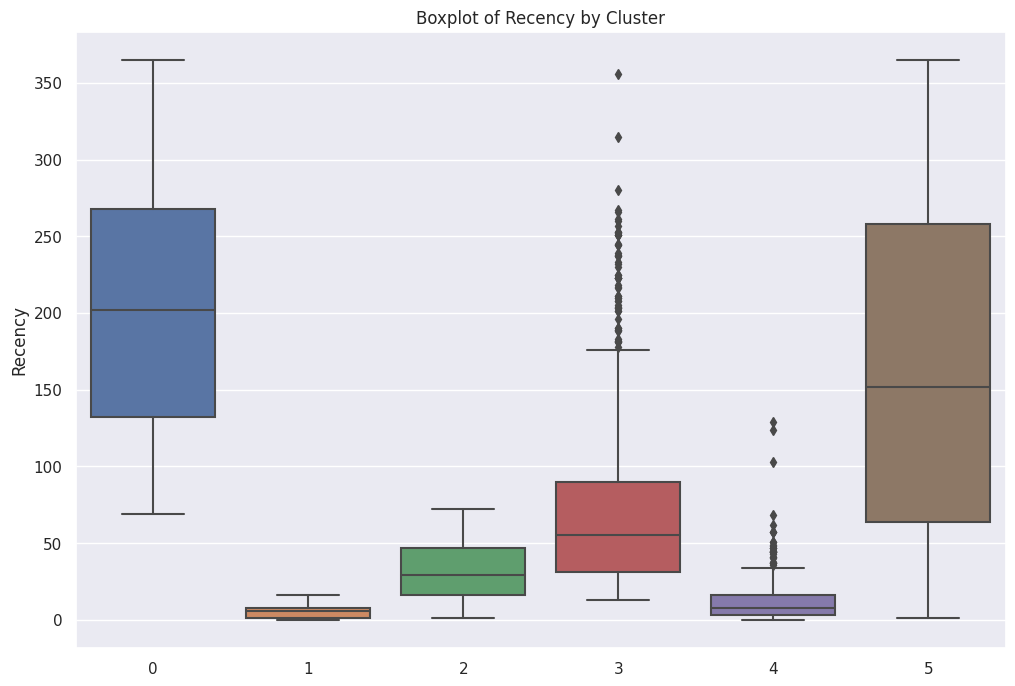

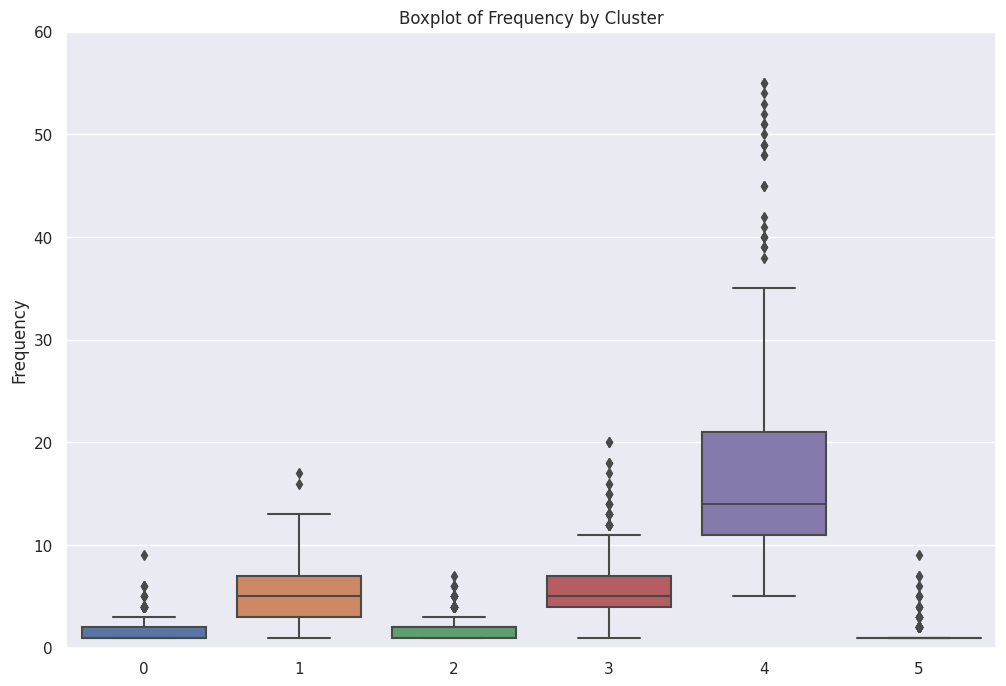

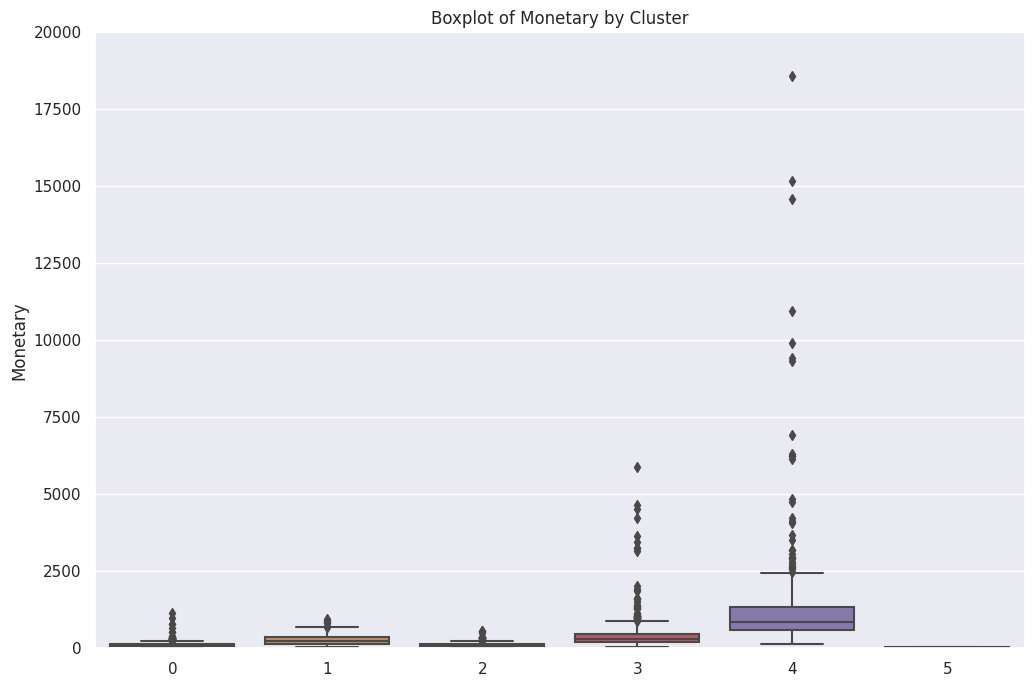

<Figure size 800x600 with 0 Axes>

In [127]:
# Cluster analysis
cluster_counts = pd.Series(cluster_labels).value_counts()
print(cluster_counts) # How many datapoints are in each cluster

cluster_counts = pd.Series({2: 912, 0: 870, 3: 702, 1: 633, 4: 492, 5: 278})

# Plotting the cluster counts
plt.figure(figsize=(8, 6))
cluster_counts.sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Data Points Across Clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=0)
plt.grid(False)
plt.show()

# Centroid values for each cluster
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm.columns)
print(cluster_centers) # These centroid calues represent the average values for each feature in each cluster

# Statistical Summary
cluster_summary = df_rfm.groupby(cluster_labels).describe()
print(cluster_summary) # Understand the central tendency and variability within each cluster

# Visualization
plt.figure(figsize=(12, 8))
sns.boxplot(x=cluster_labels, y=df_rfm['Recency'])
plt.title('Boxplot of Recency by Cluster')

plt.figure(figsize=(12, 8))
plt.ylim(0, 60)
sns.boxplot(x=cluster_labels, y=df_rfm['Frequency'])
plt.title('Boxplot of Frequency by Cluster')

plt.figure(figsize=(12, 8))
plt.ylim(0, 20000)
sns.boxplot(x=cluster_labels, y=df_rfm['Monetary'])
plt.title('Boxplot of Monetary by Cluster')


# Plot cluster centroids in 3D space
fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig)
ax.scatter(df_rfm_scaled.Recency, df_rfm_scaled.Frequency, df_rfm_scaled.Monetary, c = cluster_labels,
           edgecolor = 'k', cmap = 'Accent')
ax.scatter(cluster_centers['Recency'], cluster_centers['Frequency'], cluster_centers['Monetary'],
           c='red', marker='X', s=200, label='Centroids')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Six Clusters', fontsize=15)
ax.legend()

plt.show()